In [1]:
import crepe
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch

input, sr = librosa.load("Synth/synth.wav", sr=16000, mono=True)
input = input[:64000]

### F0 and Loudness non-torch ###

13/13 [==============================] - 12s 865ms/step
399


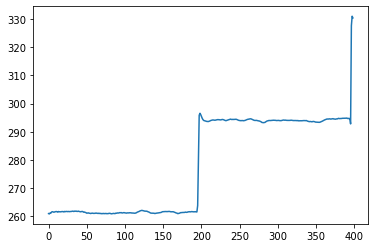

In [12]:
from encoders import Pitch_Extractor
import torch

block_size = 160

extract_f0 = Pitch_Extractor(sample_rate=sr, block_size=block_size)
pitch = extract_f0(torch.tensor(input))
print(len(pitch))
plt.plot(pitch)

400


/Users/andersbargum/Documents/Python_Code/DDSP Experiments/encoders.py:138: FutureWarning: Pass sr=16000, n_fft=2048 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f = librosa.fft_frequencies(self.sample_rate, self.n_fft)
/Users/andersbargum/opt/anaconda3/lib/python3.8/site-packages/librosa/core/convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


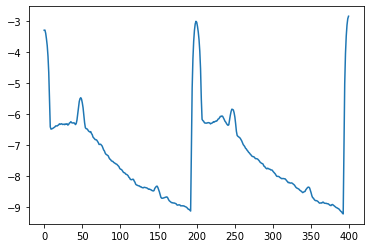

In [13]:
from encoders import Loudness_Extractor

n_fft = 2048

extract_vol = Loudness_Extractor(n_fft=2048, sample_rate=sr, block_size=block_size)
vol = extract_vol(torch.tensor(input))
print(len(vol))
plt.plot(vol)

### F0 and Loudness torch ###

In [2]:
from datasets.dataset_signal import Dataset
import torch
import yaml
from effortless_config import Config

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

sample_rate = config["preprocess"]["sample_rate"]

dataset = Dataset(config)
batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        )

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader)).size())

Synth\synth.wav:   0%|          | 0/1 [00:00<?, ?it/s]d:\Student projects\ML-AND\DDSP-Experiments\datasets\dataset_signal.py:12: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, sr = li.load(f, sample_rate, mono=True)
Synth\synth.wav: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

Size of dataset: 2 
Size of sig batch: torch.Size([2, 64000])


In [28]:
import torchaudio

class Torch_Loudness_Extractor(torch.nn.Module):
    def __init__(self, n_fft, sample_rate, block_size, device):
        super().__init__()
        self.n_fft = n_fft
        self.sample_rate = sample_rate
        self.block_size = block_size
        self.attenuate_gain = 2
        self.device = device

        self.smoothing_window = torch.hann_window(self.n_fft, dtype = torch.float32, device=self.device)

    def torch_A_weighting(self, frequencies, min_db = -45.0):
        
        # Calculate A-weighting in Decibel scale.
        freq_squared = frequencies ** 2 
        const = torch.tensor([12200, 20.6, 107.7, 737.9]) ** 2.0
        weights_in_db = 2.0 + 20.0 * (torch.log10(const[0]) + 4 * torch.log10(frequencies)
                               - torch.log10(freq_squared + const[0])
                               - torch.log10(freq_squared + const[1])
                               - 0.5 * torch.log10(freq_squared + const[2])
                               - 0.5 * torch.log10(freq_squared + const[3]))
        
        # Set minimum Decibel weight.
        if min_db is not None:
            weights_in_db = torch.max(weights_in_db, torch.tensor([min_db], dtype = torch.float32, device=self.device).to(self.device))
        
        # Transform Decibel scale weight to amplitude scale weight.
        weights = torch.exp(torch.log(torch.tensor([10.], dtype = torch.float32).to(self.device)) * weights_in_db / 10) 
        
        return weights

    def forward(self, sig):

        spec = torchaudio.transforms.Spectrogram(n_fft=self.n_fft, 
                                            win_length=self.n_fft,
                                            hop_length=self.block_size,
                                            return_complex=True)

        S = spec(sig)
                                            
        # S = torch.stft(sig,
        #             n_fft=self.n_fft,
        #             hop_length=self.block_size,
        #             win_length=self.n_fft,
        #             window=torch.hann_window(2048, device=self.device),
        #             pad_mode='constant',
        #             center=True,
        #             return_complex=True
        #             ).to(self.device)
                     
        S = torch.log(abs(S) + 1e-7)
        freqs = torch.from_numpy(librosa.fft_frequencies(self.sample_rate, self.n_fft)).to(self.device)
        a_weight = self.torch_A_weighting(freqs).to(self.device)
        S = S + a_weight.reshape(1, -1, 1)
        S = torch.mean(S, 1, dtype=torch.float32)[..., :-1]

        return S

class Torch_MFCC_Extractor(torch.nn.Module):
    def __init__(self, n_fft, sample_rate, block_size, device):
        super().__init__()
        self.n_fft = n_fft
        self.sample_rate = sample_rate
        self.block_size = block_size
        self.device = device

        self.mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            win_length=n_fft,
                                                            hop_length=block_size,
                                                            f_min=20.0,
                                                            f_max=8000.0)

    def forward(self, sig):
        length = sig.shape[-1] // self.block_size
        mel_spec = self.mel_spec(sig)
        return mel_spec[:, :, :length] #we need to calculate mfccs from this




torch.Size([2, 30, 400])


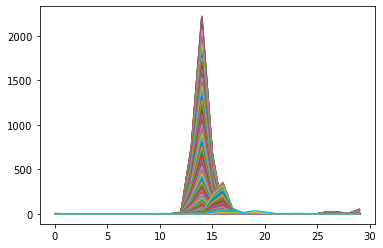

In [29]:
import matplotlib.pyplot as plt
# from encoders import Torch_Loudness_Extractor, Loudness_Extractor
block_size = 160
n_fft = 1024

mel_extractor = Torch_MFCC_Extractor(n_fft=n_fft, sample_rate=sample_rate, block_size=block_size, device='cpu')

for batch in dataloader:
    mels = mel_extractor(batch)
    print(mels.shape)

# first_batch = next(iter(dataloader))
# f, S = loudness_extractor(first_batch)

plt.plot(mels[0])

/Users/andersbargum/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


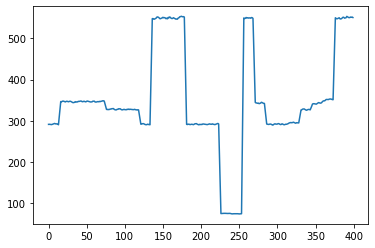

In [6]:
from encoders import Torch_Pitch_Extractor
block_size = 160

pitch_extractor = Torch_Pitch_Extractor(sample_rate=sample_rate, block_size=block_size)

for batch in dataloader:
    pitch = pitch_extractor(batch)

import matplotlib.pyplot as plt
plt.plot(pitch[0])

In [2]:
from datasets.dataset_all import Dataset, get_files
from effortless_config import Config
import yaml
import torch

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

dataset = Dataset(out_dir)
batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=True,
                                        )

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader))['signals'].size(), "\nSize of sig batch:", next(iter(dataloader))['pitches'].size(), "\nSize of sig batch:", next(iter(dataloader))['loudness'].size())

Size of dataset: 31 
Size of sig batch: torch.Size([16, 64000]) 
Size of sig batch: torch.Size([16, 400]) 
Size of sig batch: torch.Size([16, 400])
